In [1]:
from gal4H0 import *
np.random.seed(12345)
true_cosmology = FlatLambdaCDM(H0=70.,Om0=0.25)

# The GW detection probability

Below we plot the GW detection probability for the likelihood model used in our paper

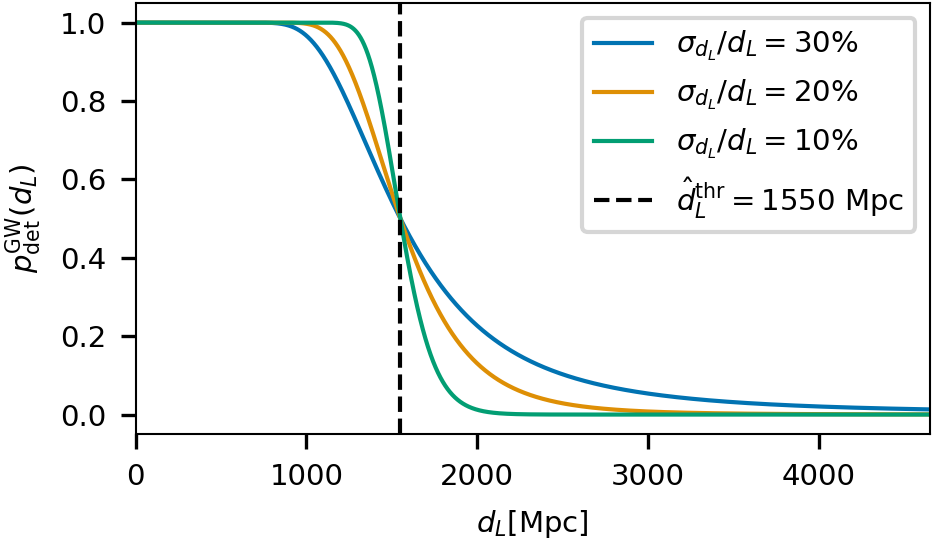

In [2]:
dl_thr=1550 # Detection threshold on observed d_L.
plt.figure(figsize=(3.3,2.0))
dlplot=np.linspace(0.1,dl_thr*3,5000)

plt.plot(dlplot,GW_detection_probability(dlplot,sigmadl=0.3*dlplot,dlthr=dl_thr),color=pal[0],label=r'$\sigma_{d_L}/d_L=30\%$')
plt.plot(dlplot,GW_detection_probability(dlplot,sigmadl=0.2*dlplot,dlthr=dl_thr),color=pal[1],label=r'$\sigma_{d_L}/d_L=20\%$')
plt.plot(dlplot,GW_detection_probability(dlplot,sigmadl=0.1*dlplot,dlthr=dl_thr),color=pal[2],label=r'$\sigma_{d_L}/d_L=10\%$')
plt.axvline(1550,label=r'$\hat{d}^{\rm thr}_L=1550$ Mpc',ls='--',color='k')

plt.xlim([0,dl_thr*3])
plt.legend()
plt.ylabel(r'$p_{\rm det}^{\rm GW}(d_L)$')
plt.xlabel(r'$d_L$[Mpc]')
plt.tight_layout()
plt.savefig('figures_paper/GW_detection_prob.pdf')


# The galaxy catalog interpolant

Below we show how to construct the galaxy catalog interpolant.

100%|██████████| 23661/23661 [02:07<00:00, 185.73it/s]


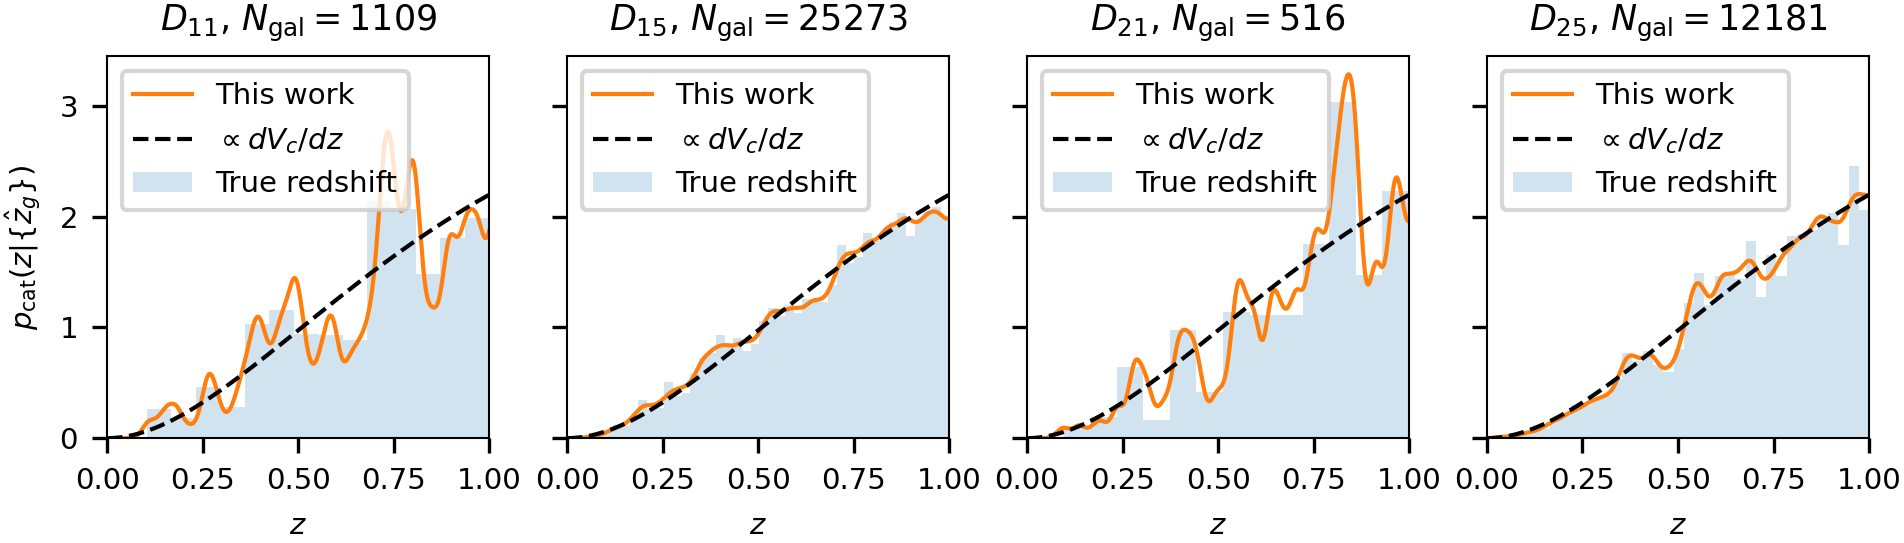

In [9]:
zcut_rate=1.0 # The maximum redshift where to simulate GWs
fig,ax=plt.subplots(1,4,figsize=(6.6,2.0),sharey=True)

zp=np.linspace(0,zcut_rate,5000)
prior=true_cosmology.differential_comoving_volume(zp).value
prior/=np.trapz(prior,zp) # Uniform in comoving volume prior

toread=['MICECAT_LOS/micecat_451.csv','MICECAT_LOS/micecat_455.csv',
       'MICECAT_LOS/micecat_901.csv','MICECAT_LOS/micecat_905.csv']

labels=[r'$D_{11}$',
        r'$D_{15}$',
        r'$D_{21}$',
        r'$D_{25}$']

for i in range(len(toread)):
    galaxies_list = np.genfromtxt(toread[i],skip_header=1) # Load galaxies from a LOS
    sigmaz=0.013*np.power(1+galaxies_list,3.)
    sigmaz[sigmaz>0.015]=0.015
    z_obs=np.random.randn(len(galaxies_list))*sigmaz+galaxies_list # Draw observed redshift 
    zinterpo,zinterpolant=build_interpolant(z_obs,sigmaz,zcut_rate) # Fit interpolant
    ax[i].hist(galaxies_list[galaxies_list<=zcut_rate],bins='auto',density=True,label=r'True redshift',alpha=0.2)
    ax[i].plot(zinterpolant,zinterpo(zinterpolant),label=r'This work')
    ax[i].plot(zp,prior,ls='--',color='k',label=r'$\propto dV_c/dz$')
    ax[i].set_xlim([0,1.0])
    ax[i].set_xlabel(r'$z$')
    ax[i].legend()
    ax[i].set_title(labels[i]+r', $N_{\rm gal}=$'+str(len(galaxies_list[galaxies_list<=zcut_rate])))

ax[0].set_ylabel(r'$p_{\rm cat}(z|\{\hat{z}_g\})$')
plt.tight_layout()
plt.savefig('figures_paper/pz.pdf')

# Effect of an incorrect Pdet

Below we show that the distribution of observed GWs is significantly different when we are in presence of selection biases and we draw initial signals in

* A redshift range with maximum set equal to the detection threshold.
* A redshift range with maximum much higher than the detection threshold.

In [3]:
galaxies_list = np.genfromtxt('MICECAT_LOS/micecat_455.csv',skip_header=1)

In [24]:
Ngw=500000 # Number of GW events to draw
sigma_dl=0.5 # Fractional uncertainty on d_L
zcut_rate=1.0 # Maximum rate where to draw 
dl_thr=1550 # Luminosity distance detetion threshold Mpc

rate_term = np.zeros_like(galaxies_list)
rate_term[galaxies_list<=zcut_rate]=1.

gw_redshift=np.random.choice(galaxies_list,size=Ngw,p=rate_term/rate_term.sum()) #  Draw GW events in 0<z<z_cut_rate
gw_true_dl=true_cosmology.luminosity_distance(gw_redshift).to('Mpc').value
gw_obs_dl=np.random.randn(len(gw_true_dl))*gw_true_dl*sigma_dl+gw_true_dl # Generate an observed luminosity distance 
gw_detected =  np.where(gw_obs_dl<dl_thr)[0] # Selection

print('You detected {:d} binaries out of {:d} simulated'.format(len(gw_detected),Ngw))

z_cor,dl_cor,dl_obs_cor=gw_redshift[gw_detected],gw_true_dl[gw_detected],gw_obs_dl[gw_detected]


You detected 76830 binaries out of 500000 simulated


In [25]:
Ngw=10000 # Number of GW events to draw
sigma_dl=0.5 # Fractional uncertainty on d_L
zcut_rate=0.3 # Maximum rate where to draw 
dl_thr=1550 # Luminosity distance detetion threshold Mpc

rate_term = np.zeros_like(galaxies_list)
rate_term[galaxies_list<=zcut_rate]=1.

gw_redshift=np.random.choice(galaxies_list,size=Ngw,p=rate_term/rate_term.sum()) #  Draw GW events in 0<z<z_cut_rate
gw_true_dl=true_cosmology.luminosity_distance(gw_redshift).to('Mpc').value
gw_obs_dl=np.random.randn(len(gw_true_dl))*gw_true_dl*sigma_dl+gw_true_dl # Generate an observed luminosity distance 
gw_detected =  np.where(gw_obs_dl<dl_thr)[0]

print('You detected {:d} binaries out of {:d} simulated'.format(len(gw_detected),Ngw))

z_wrong,dl_wrong,dl_obs_wrong=gw_redshift[gw_detected],gw_true_dl[gw_detected],gw_obs_dl[gw_detected]


You detected 7526 binaries out of 10000 simulated


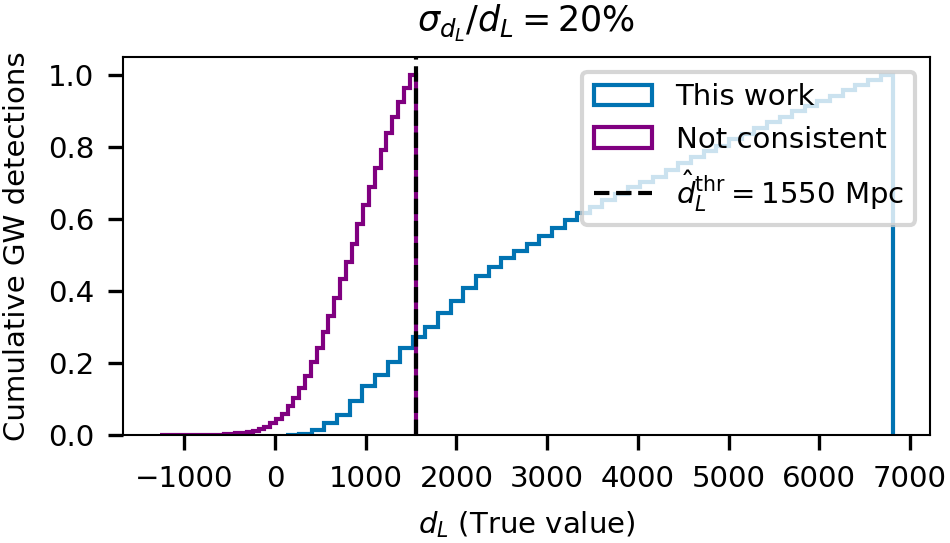

In [26]:
plt.figure(figsize=(3.3,2.0))
c=plt.hist(dl_cor,bins='auto',density=True,label=r'This work',color=pal[0],cumulative=True,histtype='step')
_=plt.hist(dl_obs_wrong,bins='auto',density=True,label=r'Not consistent',color='purple',cumulative=True,histtype='step')
plt.axvline(dl_thr,label=r'$\hat{d}^{\rm thr}_L=1550$ Mpc',ls='--',color='k')
plt.legend()
plt.title(r'$\sigma_{d_L}/d_L=20\%$')
plt.xlabel(r'$d_{L}$ (True value)')
plt.ylabel(r'Cumulative GW detections')
plt.tight_layout()
plt.savefig('figures_paper/rate_effect.pdf')

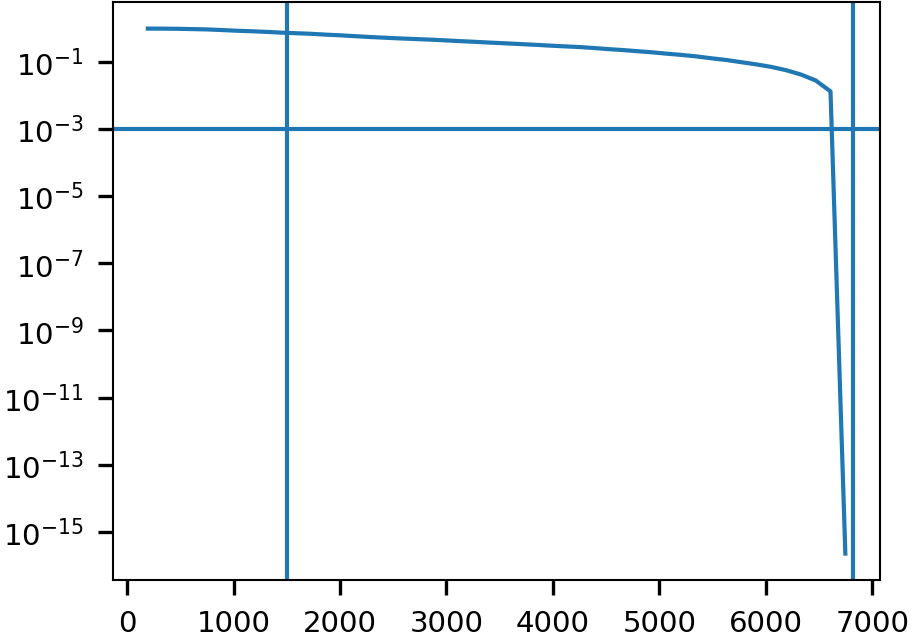

In [27]:
plt.semilogy((c[1][:-1:]+c[1][1::])*0.5,1-c[0])
plt.axhline(1e-3)
plt.axvline(1.5e3)
plt.axvline(true_cosmology.luminosity_distance(1.0).value)